## CNN trained on a subset of data

Train set is now 1/9 of the original data (10 000). Val set is also 1/9 of the original data (10 000). Test set is kept the same (90 000).


In [2]:
import torch
from torchvision import transforms
import sys
import os
from mlflow.tracking import MlflowClient
import matplotlib.pyplot as plt

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

from model_utils import ClassificationData, Model, no_augmentation
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import MLFlowLogger

torch.set_float32_matmul_precision("medium")
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
client = MlflowClient()

cuda


In this notebook, we will check how augmentation affects the performance of simple CNN.

In [3]:
class ModelAugmentation(Model):
    def __init__(self, hyperparameters, augmentations):
        super().__init__(hyperparameters)
        self.augmentations = augmentations
        # log augmentations as hyperparameters with the same dictionary
        hyperparameters.update(augmentations)
        self.hyperparameters = hyperparameters

def get_transform_info(compose_transform):
    info = {
        "randomhorizontalflip": 0,
        "randomrotation": 0,
        "colorjitter": 0,
        "randomerasing": 0,
        "normalize": 0
    }
    for t in compose_transform.transforms:
        if isinstance(t, transforms.ToTensor):
            continue
        elif isinstance(t, transforms.RandomHorizontalFlip):
            info["randomhorizontalflip"] = t.p
        elif isinstance(t, transforms.RandomRotation):
            if isinstance(t.degrees, (int, float)):
                info["randomrotation"] = t.degrees
        elif isinstance(t, transforms.ColorJitter):
            info["colorjitter"] = 1
        elif isinstance(t, transforms.RandomErasing):
            info["randomerasing"] = 1
        elif isinstance(t, transforms.Normalize):
            info["normalize"] = 1
    return info


def train_augment(transformations):
    torch.cuda.empty_cache()
    fixed_hyperparameters ={
    "learning_rate": 0.001,
    "batch_size": 64,
    "weight_decay": 0.0001,
    "dropout": 0.1,
    }
    transforms_info = get_transform_info(transformations)
    runs = 10
    for i in range(runs):
        seed = i + 123
        L.seed_everything(seed)
        torch.cuda.empty_cache()
        model = ModelAugmentation(fixed_hyperparameters, transforms_info)
        lr_monitor = LearningRateMonitor(logging_interval="step")
        logger = MLFlowLogger(save_dir="mlruns", experiment_name="CNN-different-augmentations")
        checkpoint_callback = ModelCheckpoint(monitor="val_f1_macro", mode="max", dirpath="checkpoints/cnn-different-augmentations", 
                                              filename=f"run_{i}_rhf={transforms_info["randomhorizontalflip"]}_rr={transforms_info["randomrotation"]}_cj={transforms_info["colorjitter"]}_re={transforms_info["randomerasing"]}_norm={transforms_info["normalize"]}seed={seed}" + "-{epoch:02d}-{val_f1_macro:.2f}")
        trainer = L.Trainer(max_epochs=100, logger=logger, num_sanity_val_steps=0, enable_model_summary=False, deterministic=False, callbacks=[checkpoint_callback, lr_monitor], precision="16-mixed")
        data = ClassificationData(data_dir="../data_subset",batch_size=model.hyperparameters["batch_size"], transform=transformations)
        trainer.fit(model, datamodule=data)


## Normalization vs no normalization

In [4]:
no_norm = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.4789, 0.4723, 0.4305], std=[0.2421, 0.2383, 0.2587]
    ),
])

train_augment(norm)
train_augment(no_norm)

In [12]:
def get_per_step_value(run_id):
    train_loss = client.get_metric_history(run_id, "train_loss_epoch")
    train_loss_steps, train_loss_values = [m.step for m in train_loss], [m.value for m in train_loss]
    val_loss = client.get_metric_history(run_id, "val_loss_epoch")
    val_loss_steps, val_loss_values = [m.step for m in val_loss], [m.value for m in val_loss]
    lr = client.get_metric_history(run_id, "lr-AdamW")
    lr_steps, lr_values = [m.step for m in lr], [m.value for m in lr]
    return {"train_loss": (train_loss_steps, train_loss_values), "val_loss": (val_loss_steps, val_loss_values), "lr": (lr_steps, lr_values)}

In [5]:
norm_ids = ["7b42c04763cc4a8f81a9119c2f417569","94d3949addb64bd69fec21bf3add28a3", "92926a4a4bb24e7da37d07074a1fd011", "5c11380c58e2451c80ea15fa590d23fc", "d5f163155e9b4f5dbc21017b97923b41", "d2ce6ed686b142b8b8c8a364f5e4207d",
            "f1b397a4b80945f29b9bc7d52befddce", "6a75611146e140468883296b8c13d43d", "424471aea80f4a65a475f1d37eb486a7", "09b01091badd455397aa97b16aff9966"]
no_augment_ids = ["adfbfcf3b32d41719da930355aa2eb1c", "0c12f02210c042e79595b5a6c160aace", "3146c00a04854df086f64faa6bfeb070", "16b7e705452e44569c29e33de24aa2bd", "2384adff8089472d9c6bce0858a2a9ce", "84a3b086a6524303b48ea45242fdd837",
               "011cad985bda4f4f92e0416a97e58560", "0eb1419e770946568dffdfc7556f8297", "8946ae93d2914925bbc511b8241f3dad", "54f2a45bf0df40808f8354d09a16d029"]

## RandomErasing and ColorJitter

In [ ]:
earasing = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomErasing(
    p=0.5, scale=(0.005, 0.01), ratio=(1.2, 1.8)
    ),
])
train_augment(earasing)

In [ ]:
col_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
])
train_augment(col_jitter)

In [6]:
earasing_ids = ["1c1ff5ba468d48448c5992a18cfbea01", "c404420a7de34dd1809d4771339426de", "80c6df25b2834752a44e33d5db71c4c9", "23ea5e0c66a24aa2abf31d369e904c21", "a3fcac4f07ca41f49cf7ce45a0ae3fe5", "5ec550403ae149528e287756d6dc43ae",
                "7eec3499ed3e45758a124f78a5e416d9", "63abc0f16e1b438bb6f95e16e78344af", "6e905459850c48e8b830a32e76818315", "9638c2689bbf432bb84af9c56baf7ed7"]
col_jitter_ids = ["7ecfe86a488d4486a07005fbef7e6456", "6226221f4c124276930fb6f2e423a08e", "f27ced0961ee434e8c8598fa3dc339e7", "f03c9dbf24034892b7eea52bb3a094fb", "73d03a14cf594be884cb736bad053575", "05b9ce1e813745b283f2b6100079481a",
                  "b35021d0b8994605ace2e470609225e2", "b6ef113bb6114ec793ff4b57c12682bb", "024fe9884a454241a08081bee1ee45ae", "d34ba62c6f844aef862924571539e6bd"]

## Random Rotation and Random Horizontal Flip

In [ ]:
random_rotation10 = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
random_rotation20 = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ToTensor(),
])
train_augment(random_rotation10)

In [ ]:
train_augment(random_rotation20)

In [7]:
random_rotation_10_ids = ["c108ced02d1444f7bf560214fcf98e56", "5bb882c607f84345be57c66eff926ee2", "7c07e10eb6df4d2b851e2f8863b300f2", "21d014dc24774c7e883cb93588dda2b6", "93c31facbf5f423c81163a6d932b18a5", "42bbcf8ecfbc4a12a84c7da529d5cc55",
                          "4ab4a3426edd4c738511d975a40af5c2", "d35024900404441aa3531f2c6a3c9d3e", "edf1714976c94c408fe3ca796fa2b97a", "a0fcf8a5787541ea9a3c28cf992cabf6"]
random_rotation_20_ids = ["e633f0fd9cf145f9adb28bda570d8497", "76fa4ab17dc14da792f70c69cd3b00c6", "e9846256a2a54c4fa0b83432bd9b7c2f", "07c8b6a6cb5b439683e7dffcbc0a2ef1", "224933105d7a4ff0b67e5dbf1793fe8c", "3573c8f3e89b4d9fae3b07cc5aa2d44c",
                          "fc67037fc0b2449391116ec16bddabdd", "3a90381ac0ba4dbd901cdd6c507ab4a6", "3cb840e77484421893552200096109e8", "fcb1243d5ac34d769e3f8025df71bcb9"]

In [ ]:
random_horizontal_flip_05 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])
train_augment(random_horizontal_flip_05)

In [9]:
random_horizontal_flip_05_ids = ["4729019907674c8ab49de8e01f8c40f3", "c8ed57cd4eae442d9983f6af590fc8bf", "4ee078916cab490597b4e133069e1737", "ed539ee65a754229be70e7801759152d", "54d63360d17d4de997f3e55366e06545",
                                 "70b24861abb0497f90f7a9eecc4d9c50", "d38f28035e714cd5b81ca77b0effb556", "4f32a86284e24a018c29e4b82884e045", "9cc8237a6890483698d498d598605400", "724d57999ad143e7b14d5be64e05e194"]

In [10]:
assert len(norm_ids) == len(no_augment_ids) == len(earasing_ids) == len(col_jitter_ids) == len(random_rotation_10_ids) == len(random_rotation_20_ids) == len(random_horizontal_flip_05_ids) == 10, "The number of runs for each augmentation should be the same."

Overall mean train loss: 0.1657006337400526
Overall mean val loss: 3.056196836829185
Overall mean train loss no aug: 0.1655236121788621
Overall mean val loss no aug: 3.0674796745777133
Overall std train loss: 0.009057153075754651
Overall std val loss: 0.0629697839563143
Overall std train loss no aug: 0.009423996547665469
Overall std val loss no aug: 0.07423023532807652


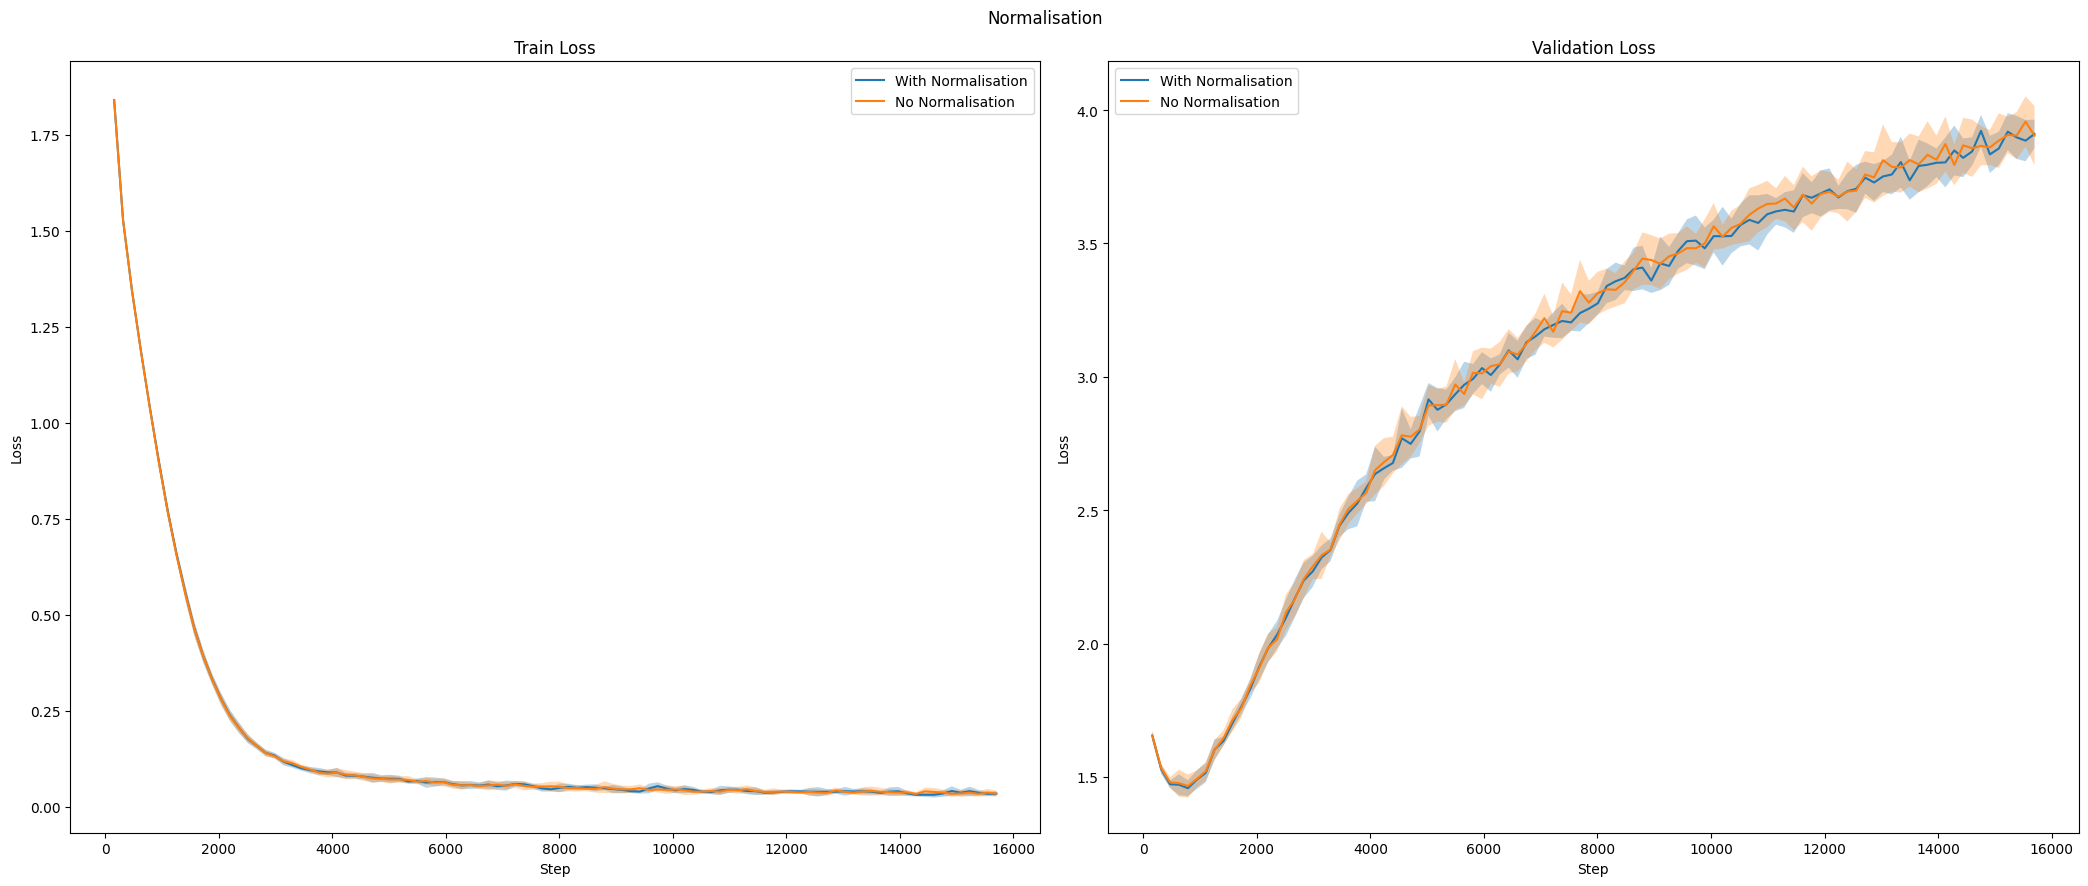

In [ ]:
# Plotting the results
import numpy as np
def plot_results(aug_ids, title):
    all_train_loss_aug = []
    all_val_loss_aug = []
    all_lr_aug = []
    steps = None
    lr_steps = None
    all_train_loss_no_aug = []
    all_val_loss_no_aug = []
    all_lr_no_aug = []
    for run_id_aug, run_id_no_aug in zip(aug_ids, no_augment_ids):
        metrics_aug = get_per_step_value(run_id_aug)
        train_loss_steps, train_loss_values = metrics_aug["train_loss"]
        val_loss_steps, val_loss_values = metrics_aug["val_loss"]
        lr_steps, lr_values = metrics_aug["lr"]
        metrics_no_aug = get_per_step_value(run_id_no_aug)
        train_loss_steps_no_aug, train_loss_values_no_aug = metrics_no_aug["train_loss"]
        val_loss_steps_no_aug, val_loss_values_no_aug = metrics_no_aug["val_loss"]
        lr_steps_no_aug, lr_values_no_aug = metrics_no_aug["lr"]
        all_train_loss_aug.append(train_loss_values)
        all_val_loss_aug.append(val_loss_values)
        all_lr_aug.append(lr_values)
        all_train_loss_no_aug.append(train_loss_values_no_aug)
        all_val_loss_no_aug.append(val_loss_values_no_aug)
        all_lr_no_aug.append(lr_values_no_aug)
        if steps is None:
            steps = train_loss_steps
        if lr_steps is None:
            lr_steps = lr_steps
    
    train_loss_values = np.array(all_train_loss_aug)
    val_loss_values = np.array(all_val_loss_aug)
    lr_values = np.array(all_lr_aug)
    train_loss_values_no_aug = np.array(all_train_loss_no_aug)
    val_loss_values_no_aug = np.array(all_val_loss_no_aug)
    lr_values_no_aug = np.array(all_lr_no_aug)
      
    mean_train_loss = np.mean(train_loss_values,axis=0)
    mean_val_loss = np.mean(val_loss_values,axis=0)
    std_train_loss = np.std(train_loss_values,axis=0)
    std_val_loss = np.std(val_loss_values,axis=0)
    
    mean_train_loss_no_aug = np.mean(train_loss_values_no_aug,axis=0)
    mean_val_loss_no_aug = np.mean(val_loss_values_no_aug,axis=0)
    std_train_loss_no_aug = np.std(train_loss_values_no_aug,axis=0)
    std_val_loss_no_aug = np.std(val_loss_values_no_aug,axis=0)
    
    fig, axs = plt.subplots(1, 2, figsize=(21, 9))
    
    # Subplot 1: Train Loss
    axs[0].plot(steps, mean_train_loss, label=f"With {title}")
    axs[0].fill_between(steps, mean_train_loss - std_train_loss, 
                          mean_train_loss + std_train_loss, alpha=0.3)
    axs[0].plot(steps, mean_train_loss_no_aug, label=f"No {title}")
    axs[0].fill_between(steps, mean_train_loss_no_aug - std_train_loss_no_aug, 
                          mean_train_loss_no_aug + std_train_loss_no_aug, alpha=0.3)
    axs[0].set_title("Train Loss")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    
    # Subplot 2: Validation Loss
    axs[1].plot(steps, mean_val_loss, label=f"With {title}")
    axs[1].fill_between(steps, mean_val_loss - std_val_loss, 
                          mean_val_loss + std_val_loss, alpha=0.3)
    axs[1].plot(steps, mean_val_loss_no_aug, label=f"No {title}")
    axs[1].fill_between(steps, mean_val_loss_no_aug - std_val_loss_no_aug, 
                          mean_val_loss_no_aug + std_val_loss_no_aug, alpha=0.3)
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    

    fig.suptitle(title)
    plt.tight_layout()
    print("Overall mean train loss:", np.mean(mean_train_loss))
    print("Overall mean val loss:", np.mean(mean_val_loss))
    print("Overall mean train loss no aug:", np.mean(mean_train_loss_no_aug))
    print("Overall mean val loss no aug:", np.mean(mean_val_loss_no_aug))
    print("Overall std train loss:", np.mean(std_train_loss))
    print("Overall std val loss:", np.mean(std_val_loss))
    print("Overall std train loss no aug:", np.mean(std_train_loss_no_aug))
    print("Overall std val loss no aug:", np.mean(std_val_loss_no_aug))
    plt.show()
plot_results(norm_ids, "Normalisation")

Overall mean train loss: 0.20690470540896058
Overall mean val loss: 2.7750874990224834
Overall mean train loss no aug: 0.1655236121788621
Overall mean val loss no aug: 3.0674796745777133
Overall std train loss: 0.008214760536874748
Overall std val loss: 0.06116444001447606
Overall std train loss no aug: 0.009423996547665469
Overall std val loss no aug: 0.07423023532807652


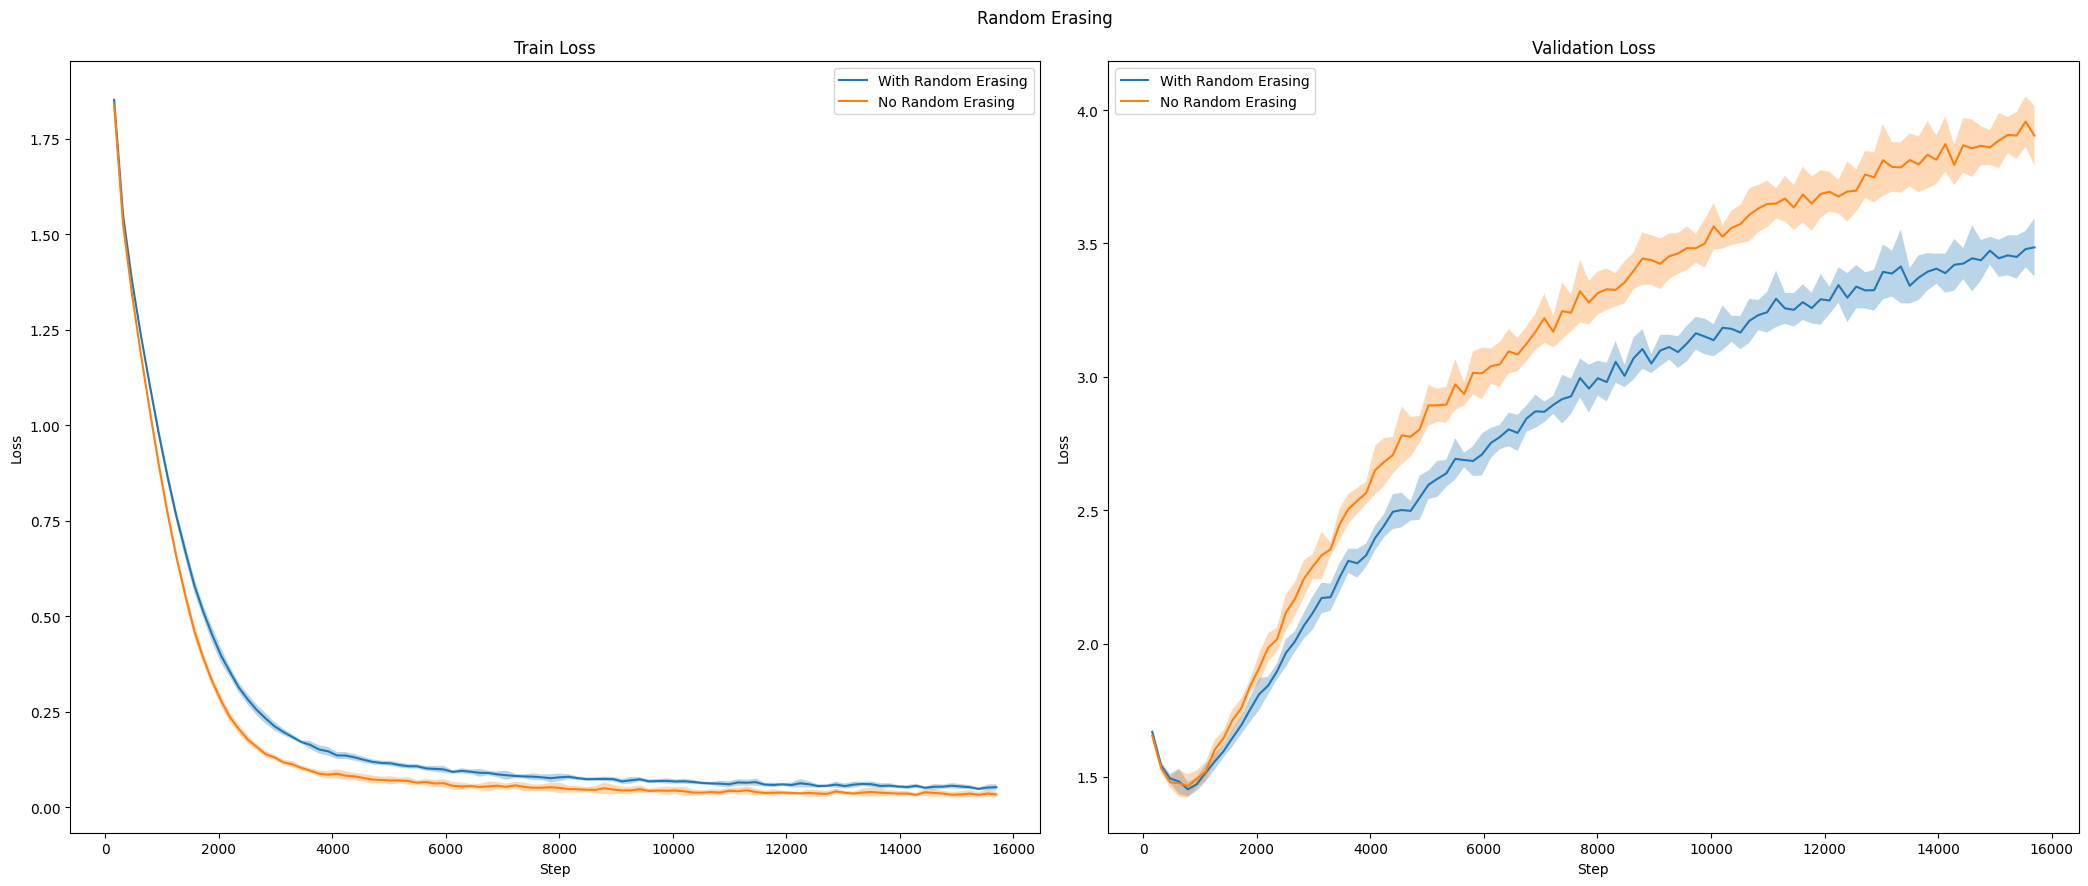

In [34]:
plot_results(earasing_ids, "Random Erasing")

Overall mean train loss: 0.18889754420146354
Overall mean val loss: 2.976839133620262
Overall mean train loss no aug: 0.1655236121788621
Overall mean val loss no aug: 3.0674796745777133
Overall std train loss: 0.008353939637549254
Overall std val loss: 0.06195623118724243
Overall std train loss no aug: 0.009423996547665469
Overall std val loss no aug: 0.07423023532807652


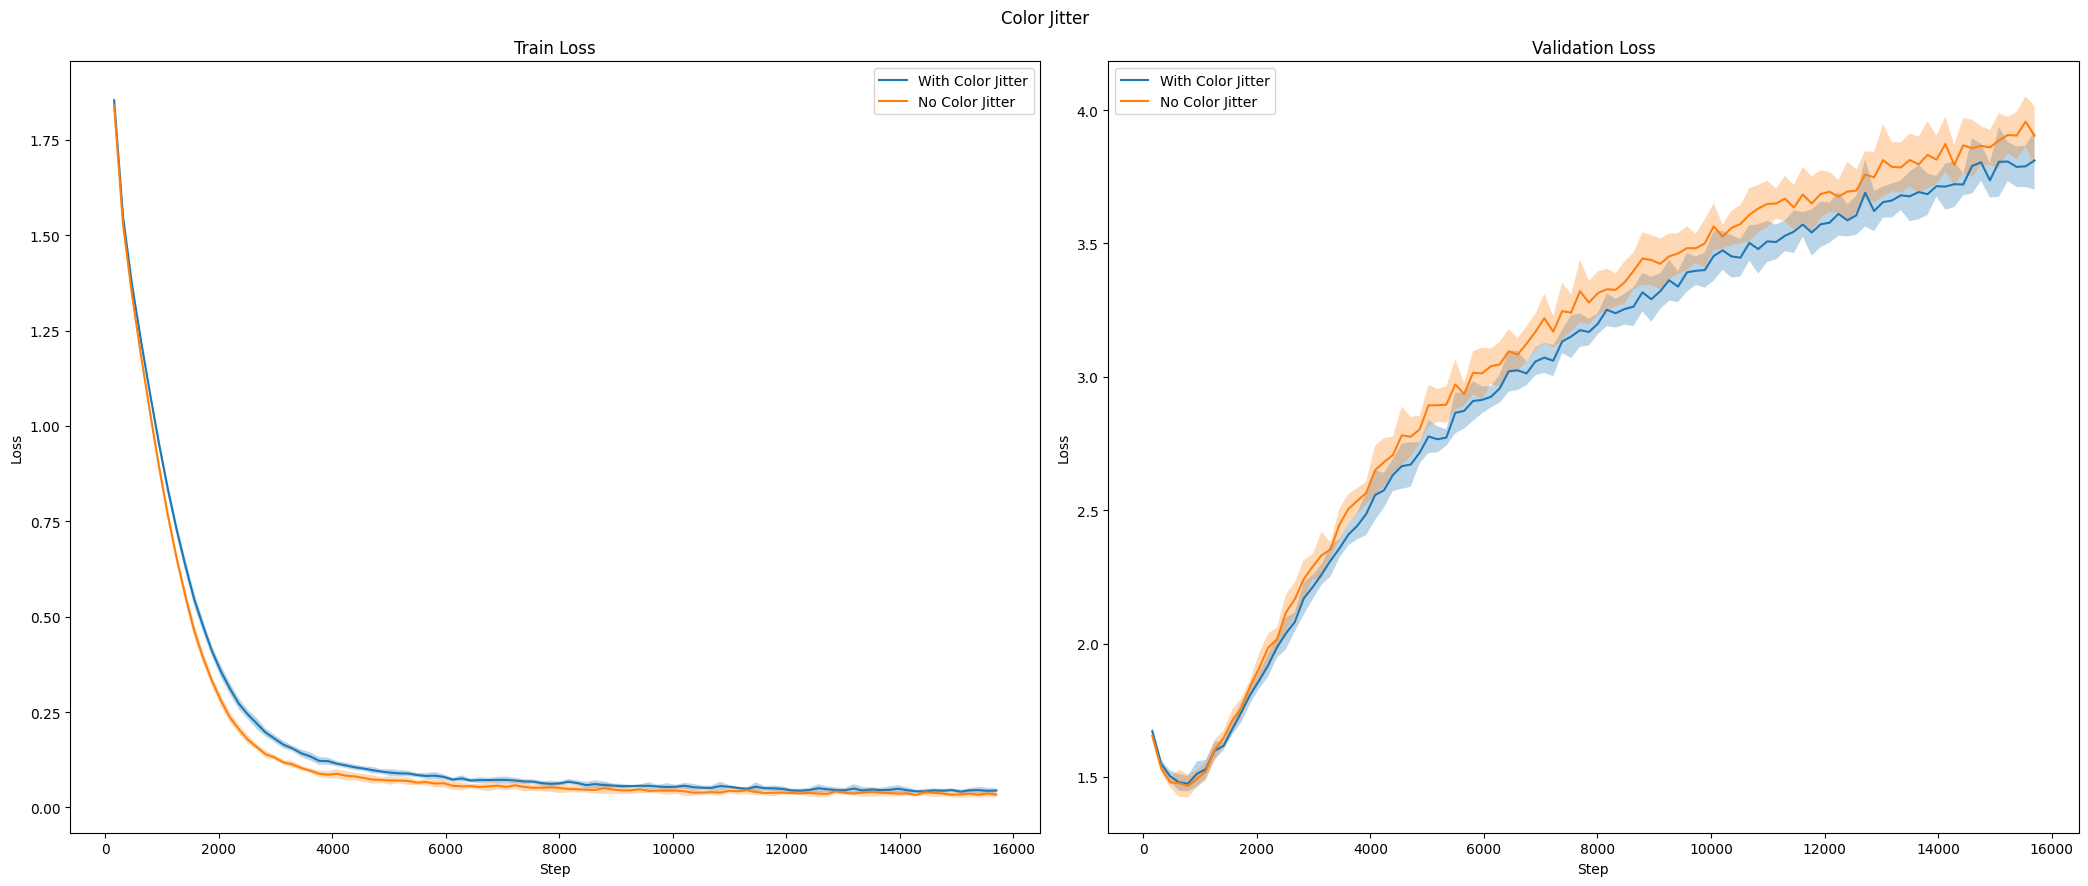

In [35]:
plot_results(col_jitter_ids, "Color Jitter")

Overall mean train loss: 0.33208733756840236
Overall mean val loss: 2.3238361966609955
Overall mean train loss no aug: 0.1655236121788621
Overall mean val loss no aug: 3.0674796745777133
Overall std train loss: 0.008965946577117363
Overall std val loss: 0.0500747407353164
Overall std train loss no aug: 0.009423996547665469
Overall std val loss no aug: 0.07423023532807652


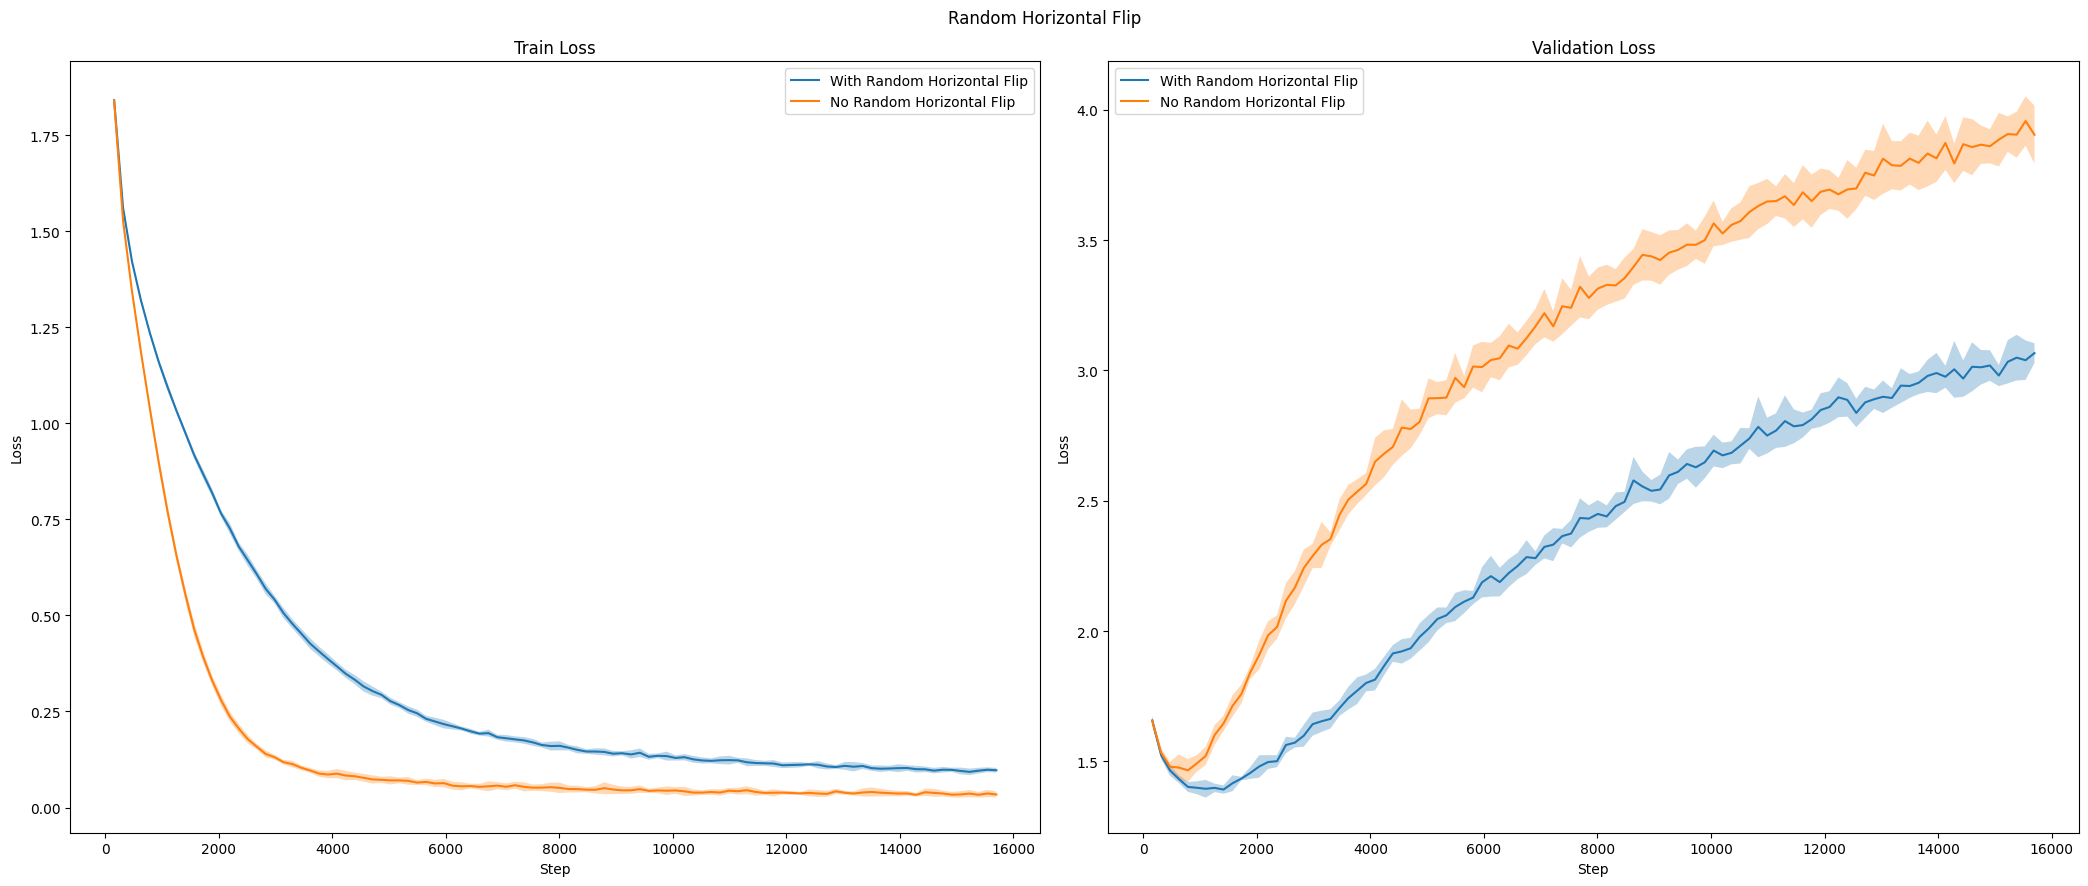

In [36]:
plot_results(random_horizontal_flip_05_ids, "Random Horizontal Flip")

Overall mean train loss augmentation 1: 0.4443994696140289
Overall mean train loss augmentation 2: 0.6729850616455079
Overall mean train loss no aug: 0.1655236121788621
Overall mean val loss augmentation 1: 1.9782911714315414
Overall mean val loss augmentation 2: 1.7035381710529327
Overall mean val loss no aug: 3.0674796745777133


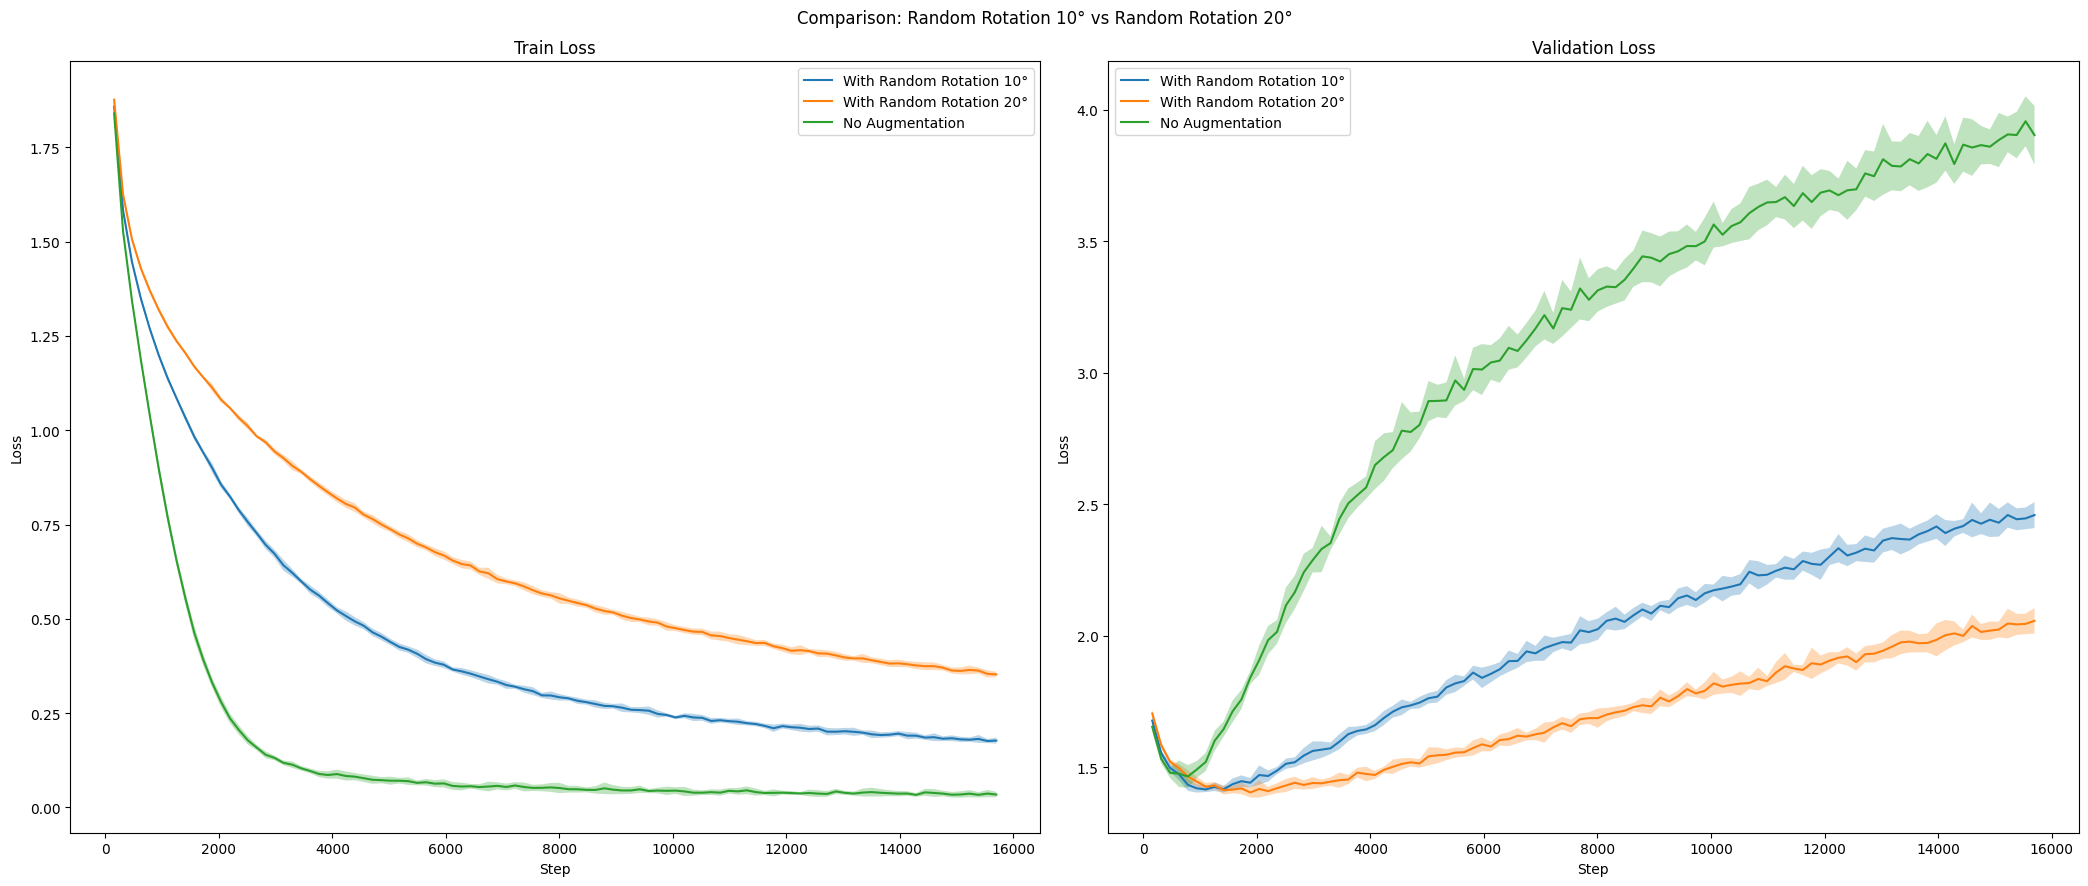

In [37]:
def plot_results(aug_ids1, aug_ids2, title1, title2):
    all_train_loss_aug1 = []
    all_val_loss_aug1 = []
    all_lr_aug1 = []
    all_train_loss_aug2 = []
    all_val_loss_aug2 = []
    all_lr_aug2 = []
    all_train_loss_no_aug = []
    all_val_loss_no_aug = []
    all_lr_no_aug = []
    
    steps = None
    lr_steps = None

    for run_id_aug, run_id_no_aug in zip(aug_ids1, no_augment_ids):
        metrics_aug = get_per_step_value(run_id_aug)
        train_loss_steps, train_loss_values = metrics_aug["train_loss"]
        val_loss_steps, val_loss_values = metrics_aug["val_loss"]
        lr_steps_val, lr_values = metrics_aug["lr"]
        metrics_no_aug = get_per_step_value(run_id_no_aug)
        train_loss_steps_no_aug, train_loss_values_no_aug = metrics_no_aug["train_loss"]
        val_loss_steps_no_aug, val_loss_values_no_aug = metrics_no_aug["val_loss"]
        lr_steps_no_aug, lr_values_no_aug = metrics_no_aug["lr"]
        all_train_loss_aug1.append(train_loss_values)
        all_val_loss_aug1.append(val_loss_values)
        all_lr_aug1.append(lr_values)
        all_train_loss_no_aug.append(train_loss_values_no_aug)
        all_val_loss_no_aug.append(val_loss_values_no_aug)
        all_lr_no_aug.append(lr_values_no_aug)
        if steps is None:
            steps = train_loss_steps
            lr_steps = lr_steps_val
    
    for run_id_aug in aug_ids2:
        metrics_aug = get_per_step_value(run_id_aug)
        train_loss_steps, train_loss_values = metrics_aug["train_loss"]
        val_loss_steps, val_loss_values = metrics_aug["val_loss"]
        lr_steps_val, lr_values = metrics_aug["lr"]
        
        all_train_loss_aug2.append(train_loss_values)
        all_val_loss_aug2.append(val_loss_values)
        all_lr_aug2.append(lr_values)
        
        if steps is None:
            steps = train_loss_steps
        if lr_steps is None:
            lr_steps = lr_steps_val

    train_loss_aug1 = np.array(all_train_loss_aug1)
    val_loss_aug1 = np.array(all_val_loss_aug1)
    lr_aug1 = np.array(all_lr_aug1)
    train_loss_aug2 = np.array(all_train_loss_aug2)
    val_loss_aug2 = np.array(all_val_loss_aug2)
    lr_aug2 = np.array(all_lr_aug2)
    train_loss_no_aug = np.array(all_train_loss_no_aug)
    val_loss_no_aug = np.array(all_val_loss_no_aug)
    lr_no_aug = np.array(all_lr_no_aug)
    
    # Compute per-step mean and standard deviation for each metric and group
    mean_train_loss_aug1 = np.mean(train_loss_aug1, axis=0)
    std_train_loss_aug1 = np.std(train_loss_aug1, axis=0)
    mean_val_loss_aug1 = np.mean(val_loss_aug1, axis=0)
    std_val_loss_aug1 = np.std(val_loss_aug1, axis=0)
    
    mean_train_loss_aug2 = np.mean(train_loss_aug2, axis=0)
    std_train_loss_aug2 = np.std(train_loss_aug2, axis=0)
    mean_val_loss_aug2 = np.mean(val_loss_aug2, axis=0)
    std_val_loss_aug2 = np.std(val_loss_aug2, axis=0)
    
    mean_train_loss_no_aug = np.mean(train_loss_no_aug, axis=0)
    std_train_loss_no_aug = np.std(train_loss_no_aug, axis=0)
    mean_val_loss_no_aug = np.mean(val_loss_no_aug, axis=0)
    std_val_loss_no_aug = np.std(val_loss_no_aug, axis=0)
    
    # Create a figure with three subplots: train loss, validation loss, and learning rate
    fig, axs = plt.subplots(1, 2, figsize=(21, 9))
    
    # Subplot 1: Train Loss
    axs[0].plot(steps, mean_train_loss_aug1, label=f"With {title1}")
    axs[0].fill_between(steps, mean_train_loss_aug1 - std_train_loss_aug1,
                          mean_train_loss_aug1 + std_train_loss_aug1, alpha=0.3)
    
    axs[0].plot(steps, mean_train_loss_aug2, label=f"With {title2}")
    axs[0].fill_between(steps, mean_train_loss_aug2 - std_train_loss_aug2,
                          mean_train_loss_aug2 + std_train_loss_aug2, alpha=0.3)
    
    axs[0].plot(steps, mean_train_loss_no_aug, label="No Augmentation")
    axs[0].fill_between(steps, mean_train_loss_no_aug - std_train_loss_no_aug,
                          mean_train_loss_no_aug + std_train_loss_no_aug, alpha=0.3)
    
    axs[0].set_title("Train Loss")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    
    # Subplot 2: Validation Loss
    axs[1].plot(steps, mean_val_loss_aug1, label=f"With {title1}")
    axs[1].fill_between(steps, mean_val_loss_aug1 - std_val_loss_aug1,
                          mean_val_loss_aug1 + std_val_loss_aug1, alpha=0.3)
    
    axs[1].plot(steps, mean_val_loss_aug2, label=f"With {title2}")
    axs[1].fill_between(steps, mean_val_loss_aug2 - std_val_loss_aug2,
                          mean_val_loss_aug2 + std_val_loss_aug2, alpha=0.3)
    
    axs[1].plot(steps, mean_val_loss_no_aug, label="No Augmentation")
    axs[1].fill_between(steps, mean_val_loss_no_aug - std_val_loss_no_aug,
                          mean_val_loss_no_aug + std_val_loss_no_aug, alpha=0.3)
    
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    
    fig.suptitle(f"Comparison: {title1} vs {title2}")
    plt.tight_layout()
    
    # Optionally, print overall statistics
    print("Overall mean train loss augmentation 1:", np.mean(mean_train_loss_aug1))
    print("Overall mean train loss augmentation 2:", np.mean(mean_train_loss_aug2))
    print("Overall mean train loss no aug:", np.mean(mean_train_loss_no_aug))
    print("Overall mean val loss augmentation 1:", np.mean(mean_val_loss_aug1))
    print("Overall mean val loss augmentation 2:", np.mean(mean_val_loss_aug2))
    print("Overall mean val loss no aug:", np.mean(mean_val_loss_no_aug))
    plt.show()

plot_results(random_rotation_10_ids, random_rotation_20_ids, "Random Rotation 10°", "Random Rotation 20°")